# Get started with Metrics Tracking and Monitoring

This notebook demonstrates how to use Evidently to:
* Generate a model performance report and calculate associated metrics.
* Log model metrics to MLFlow.
* Store the model in MLFlow as an artifact.
* Store the model performance report in MLFlow as an artifact.

In [2]:
%load_ext autoreload
%autoreload 2

import joblib
import pandas as pd
from pathlib import Path
from sklearn import ensemble, model_selection
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

More information about the dataset can be found in UCI machine learning repository: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset

Acknowledgement: Fanaee-T, Hadi, and Gama, Joao, 'Event labeling combining ensemble detectors and background knowledge', Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg

In [5]:
# Download original dataset with: python src/pipelines/load_data.py 

raw_data = pd.read_csv("../data/raw_data.csv")
raw_data.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

## Define column mapping

In [6]:
target = 'cnt'
prediction = 'prediction'
numerical_features = ['temp', 'atemp', 'hum', 'windspeed', 'mnth', 'hr', 'weekday']
categorical_features = ['season', 'holiday', 'workingday', ]

In [7]:
sample_data = raw_data.set_index('dteday').loc['2011-01-01 00:00:00':'2011-01-28 23:00:00'].reset_index()

print(sample_data.shape)

(594, 17)


In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    sample_data[numerical_features + categorical_features],
    sample_data[target],
    test_size=0.3
)

print(X_train.shape)
print(X_test.shape)

(415, 10)
(179, 10)


## Train a  Model

In [9]:
model = ensemble.RandomForestRegressor(random_state = 0, n_estimators = 50)
model.fit(X_train, y_train) 

model_path = Path('../models/model.joblib')
joblib.dump(model, model_path)

['../models/model.joblib']

In [10]:
model

RandomForestRegressor(n_estimators=50, random_state=0)

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

preds = model.predict(X_test)

me = mean_squared_error(y_test, preds)
mae = mean_absolute_error(y_test, preds)

print(me, mae)

261.8093162011173 10.70826815642458


## Build the model validation report

In [12]:
report = X_test.copy()
report['target'] = y_test
report['prediction'] = preds

report.head()

temp   atemp   hum  windspeed  mnth  hr  weekday  season  holiday  \
520  0.14  0.1364  0.59     0.1940     1  20        1       1        0   
228  0.16  0.1970  0.86     0.0896     1  21        2       1        0   
238  0.16  0.1364  0.59     0.3284     1   9        3       1        0   
394  0.28  0.3030  0.87     0.0896     1  11        3       1        0   
475  0.06  0.1061  0.41     0.0896     1  21        6       1        0   

     workingday  target  prediction  
520           1      81       68.32  
228           1      20       42.44  
238           1      81      114.90  
394           1      52       65.34  
475           0      39       37.70

# Metrics Tracking with DVCLive

# DVC Report

params.yaml

| model        |   random_state |   n_estimators |
|--------------|----------------|----------------|
| RandomForest |              0 |             50 |

metrics.json

|      me |    mae |
|---------|--------|
| 261.809 | 10.708 |

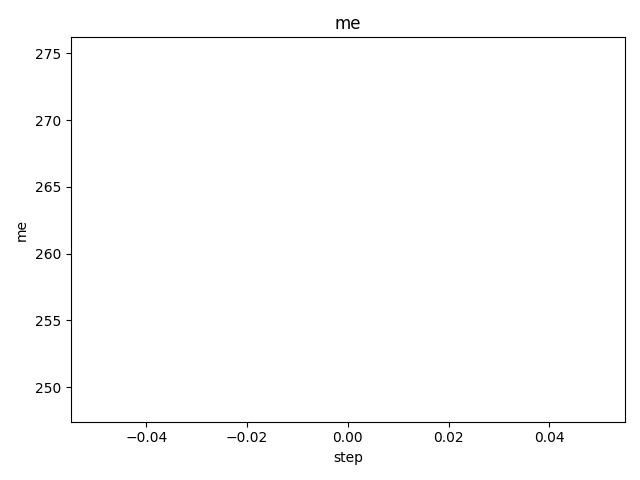

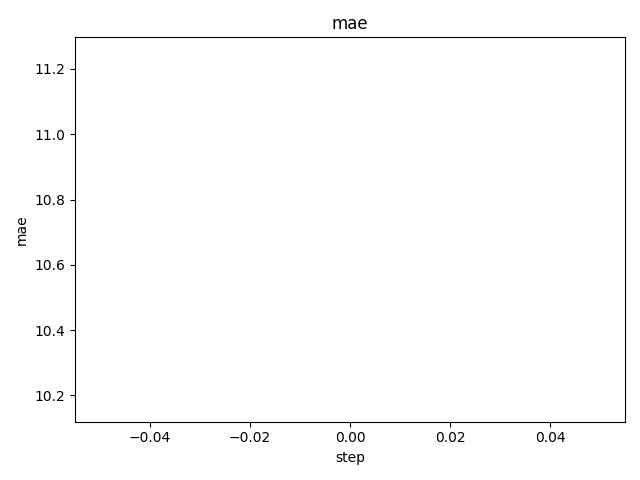


In [14]:
from dvclive import Live

# DVCLive: Log Model

with Live(dir='../results/dvclive',
          save_dvc_exp=True, 
          report='notebook') as live:

    # Log params 
    live.log_param('model', 'RandomForest') 
    live.log_params({'random_state': 0, 'n_estimators': 50})

    # Log metrics
    live.log_metric('me', round(me, 3))
    live.log_metric('mae', round(mae, 3))
    
    
    # Log RandomForestRegressor model
    live.log_artifact(
        path = '../models/model.joblib',
        type = 'model', 
        name = "random-forest", # Note: only lowercase letter
        desc = "This a model version 3 description added with update_model_version() method",
        labels=["RandomForestRegressor", "bike-sharing"],
        meta = {
            'features': list(X_test.columns),
            'me': str(round(me, 3)),         # Note: 'float' is not supported by 'dvc.yaml', convert to 'str'
            'mae': str(round(mae, 3))        # It's better to use 'log_metrics' or 'log_params' for float values
        },
        copy = True,
        cache  = True
    )